In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
import numpy as np
from numpy import array

import scipy
from scipy import stats

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

import seaborn as sns
import matplotlib.pyplot as plt
from math import pi
from matplotlib.path import Path
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D

from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.model_selection import GridSearchCV,cross_validate
from sklearn import model_selection
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,cross_val_score, StratifiedKFold, KFold 
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier,AdaBoostClassifier,IsolationForest,StackingClassifier,HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score,balanced_accuracy_score,precision_score,recall_score,confusion_matrix,f1_score,fbeta_score,roc_auc_score,classification_report,make_scorer,balanced_accuracy_score
from mlxtend.classifier import StackingClassifier,StackingCVClassifier
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,StandardScaler,MinMaxScaler,RobustScaler,Binarizer

import warnings 
warnings.filterwarnings(action='ignore')

In [2]:
def data_organization(ml_list):
    
    #### 공정 진단 비교 기준
    Trained_All = pd.concat([X_train,y_train],axis=1)
    Trained_Normal = Trained_All[Trained_All['Score'] ==0].drop(['Score'],axis=1)

    #### Test 데이터 업로드 & 변수 선택 적용
    pred_df = pd.read_csv('Test.csv')
    pred_df = pred_df[ttest_vals]

    #### Test Data 예측 [ 선택된 학습모델 기준]
    pred = Final_ML.predict(pred_df)
    pred_proba = Final_ML.predict_proba(pred_df)

    pred_df['Score'] = pd.DataFrame(pred)
    pred_proba_df = pd.DataFrame(pred_proba).rename(columns={0:'Prob_Normal',1:'Prob_Fault'})

    pred_df = pd.concat([pred_df,pred_proba_df],axis=1)

    pred_normal = pred_df[pred_df['Score'] == 0].drop(['Score'],axis=1).reset_index(drop=True)
    pred_fault = pred_df[pred_df['Score'] == 1].drop(['Score'],axis=1).reset_index(drop=True)

    #### Fault Prediction 개별 ID 부여 
    dfs = []

    for i in range(0,len(pred_fault)):
        ids = 'ID_20231108_'+str(i)
        dfs.append(ids)

    pred_fault['_id'] = pd.DataFrame(np.array(dfs))
    df_fault_proba = pred_fault[['_id','Prob_Normal','Prob_Fault']]

    Trained_Normal.shape,pred_normal.shape,pred_fault.shape

    #### 주요변수 출력
    columns = X_train.columns.tolist()
    feature_importance = Final_ML.fit(X_train,y_train).feature_importances_.tolist()

    df_feature_importance = pd.DataFrame()
    df_feature_importance['Columns']  = pd.DataFrame(np.array(columns))
    df_feature_importance['Rank'] = pd.DataFrame(np.array(feature_importance))

    imp_cols = df_feature_importance.sort_values(by='Rank',ascending=False).head()['Columns'].tolist()
    print(model_names[ml_list])
    print('공정 최적화 대상 변수 --> ',imp_cols)

    #### 공정 최적화 대상 데이터셋 완성
    fault_optimize_df = pred_fault[['_id'] + imp_cols]
    fault_ids = fault_optimize_df['_id'].tolist()

    return Trained_Normal,imp_cols,pred_fault,df_fault_proba,fault_ids,fault_optimize_df

In [3]:
def make_lists(_id,cols):
    
    df_oneline = fault_optimize_df[fault_optimize_df['_id'] == fault_ids[_id]]
    col = pd.DataFrame(pred_fault[imp_cols[cols]]).columns[0]
    
    #### 현재 변수 값
    df_oneline_col = df_oneline[col]
    col_value = df_oneline_col.values[0]
    
    #### 정상(학습) 데이터 중앙값
    median_val = Trained_Normal[imp_cols[cols]].median()
    
    return df_oneline,col,col_value,median_val  


def imp_diagnosis(_id,cols,lower_quantile,col_range):
    
    #### Fault Prediction 해당 _ID & 정보 출력 
    df_oneline = fault_optimize_df[fault_optimize_df['_id'] == fault_ids[_id]]
    col = pd.DataFrame(fault_optimize_df[imp_cols[cols]]).columns[0]

    df_oneline_col = df_oneline[col]
    col_value = df_oneline_col.values[0]

    print(col,' = ',col_value)
    print('\n')
    
    ### 정상(학습) 데이터 해당 변수 통계량 비교 
    print('하위 측정값 설정:',Trained_Normal[imp_cols[cols]].quantile(lower_quantile))
    print('중앙 측정값 :',Trained_Normal[imp_cols[cols]].median())
    print('상위 10% 측정값 :',Trained_Normal[imp_cols[cols]].quantile(0.9))

    print('\n')
    print('진단 결과')
    
    if (col_value >= Trained_Normal[imp_cols[cols]].quantile(lower_quantile)) & (col_value <= Trained_Normal[imp_cols[cols]].quantile(0.9)):
        
        print('Value in Set Normal Quantile Range')
        print(col, ' --> 현재 값 유지')
        print('\n')
        print('==========================================================================================')
        print('\n')
        
    else:
        
        if (col_value > Trained_Normal[imp_cols[cols]].quantile(0.9)):

            print(col,'하향 조정 대상-->  -',col_value - Trained_Normal[imp_cols[cols]].quantile(0.9))
            print('\n')

            if col_value - Trained_Normal[imp_cols[cols]].quantile(0.9) >= col_range:

                df_oneline[[imp_cols[cols]]] = df_oneline[imp_cols[cols]].iloc[0] - (col_value - Trained_Normal[imp_cols[cols]].quantile(0.9))
                print('추천 의사결정 --> ',col, '조정')
            else:
                print('추천 의사결정 --> ',col, '유지')

        elif (col_value < Trained_Normal[imp_cols[cols]].quantile(lower_quantile)):

            print(col,'상향 조정 대상-->  +',Trained_Normal[imp_cols[cols]].quantile(lower_quantile) - col_value)
            print('\n')

            if Trained_Normal[imp_cols[cols]].quantile(lower_quantile) - col_value >= col_range:

                df_oneline[[imp_cols[cols]]] = df_oneline[imp_cols[cols]].iloc[0] + Trained_Normal[imp_cols[cols]].quantile(lower_quantile) - col_value
                print('추천 의사결정 --> ',col, '조정')
            else:
                print('추천 의사결정 --> ',col, '유지')


        elif (col_value > Trained_Normal[imp_cols[cols]].quantile(lower_quantile)):

            print(col,'하향 조정 대상--> ',Trained_Normal[imp_cols[cols]].quantile(lower_quantile) - col_value)
            print('\n')

            if np.abs(Trained_Normal[imp_cols[cols]].quantile(lower_quantile) - col_value) >= col_range:

                df_oneline[[imp_cols[cols]]] = df_oneline[imp_cols[cols]].iloc[0] + Trained_Normal[imp_cols[cols]].quantile(lower_quantile) - col_value
                print('추천 의사결정 --> ',col, '조정')

            else:
                print('추천 의사결정 --> ',col, '유지')

        print('\n')
        print('==========================================================================================')
        print('\n')
    
    df_col = df_oneline[[imp_cols[cols]]]
    
    return df_col

        
def comprehensive_fault_diagnosis(_id,lower_quantile,col_range):
    
    col_name = []
    list_col_value = []
    list_median_value = []

    for cols in range(0,len(imp_cols)):
        df_oneline,col,col_value,median_val = make_lists(_id,cols)

        col_name.append(col)
        list_col_value.append(col_value)
        list_median_value.append(median_val)
        
    print('Id --> ',df_oneline['_id'].iloc[0])
    print('Normal Probability : ',df_fault_proba[df_fault_proba['_id'] == fault_ids[_id]]['Prob_Normal'].iloc[0])
    print('Fault Probability : ',df_fault_proba[df_fault_proba['_id'] == fault_ids[_id]]['Prob_Fault'].iloc[0])
    print('\n')
    print('Columns:',col_name)
    print('Column Values:',list_col_value)
    print('Median Normal Values:',list_median_value)
    print('Confidence Range = ','| Input - Upper/Lower Boundary | ±',col_range)
    print('===========================================================================================')
    
    #### 진단 결과
    
    print('Diagnosis Result -->')
    print('\n')

    dfs = []
    for cols in range(0,len(imp_cols)):

        df_col = imp_diagnosis(_id,cols,lower_quantile,col_range)
        dfs.append(df_col)

    df_cols = pd.DataFrame(np.array(dfs).reshape(-1,1)).T
    df_cols.columns = imp_cols
    input_adjusted = df_cols

    #### 폴리곤 차트
    df = pd.DataFrame({'Columns': col_name, 'Top_Features': list_col_value, 'Median_Normal': list_median_value})
    df = df.T.rename(columns=df.T.iloc[0]).iloc[1:].reset_index().rename(columns={'index':'Type'})
    
    labels = df.columns[1:]
    num_labels = len(labels)    

    angles = [x/float(num_labels)*(2*pi) for x in range(num_labels)] 
    angles += angles[:1]   

    my_palette = plt.cm.get_cmap("winter", len(df.index)) 
    sns.set(font_scale=1.0)
    fig = plt.figure(figsize=(18,18))
    #plt.grid(True)
    fig.set_facecolor('white')
    ax = fig.add_subplot(polar=True)

    for i, row in df.iterrows():    
        color = my_palette(i)    
        data = df.iloc[i].drop('Type').tolist()    
        data += data[:1]        

        ax.set_theta_offset(pi / 2) 
        ax.set_theta_direction(-1) 

        plt.xticks(angles[:-1], labels, fontsize=25) 
        ax.tick_params(axis='x', which='major', pad=65) 
        ax.set_rlabel_position(0) 

        plt.suptitle('ID = ' + fault_ids[_id],fontsize=30)
        #plt.title('ID = ' + fault_ids[_id],fontsize=30)
        plt.ylim(0,df.T.iloc[1:].max().sort_values(ascending=False)[0])

        ax.plot(angles, data, color=color, linewidth=2, linestyle='solid', label=row.Type)
        ax.fill(angles, data, color=color, alpha=0.45)


    for g in ax.yaxis.get_gridlines():
        g.get_path()._interpolation_steps = len(labels) 

    spine = Spine(axes=ax,spine_type='circle',path=Path.unit_regular_polygon(len(labels)))
    spine.set_transform(Affine2D().scale(.5).translate(.5, .5)+ax.transAxes)           
    ax.spines = {'polar':spine} 

    plt.legend(loc=(1.0,1.0))
    plt.show()
    
    return input_adjusted


def optimization(_id):
    
    input_df = pred_fault[pred_fault['_id'] == fault_ids[_id]]
    input_df[input_adjusted.columns.tolist()] = input_adjusted.iloc[0].tolist()

    input_revised = input_df.drop(['Prob_Normal','Prob_Fault','_id'],axis=1)

    ML = models[ml_list]
    ML.fit(X_train,y_train)

    pred_revised = ML.predict(input_revised)
    pred_proba_revised = ML.predict_proba(input_revised)

    print(fault_ids[_id],'Optimization Result -->')
    print('\n')
    print('Label :',pred_revised[0])
    print('Normal Probability --> ',pred_proba_revised[0][0])
    print('Fault Probability --> ',pred_proba_revised[0][1])
    print('\n')
    
    if pred_revised == 0:
        print('Predicted --> Normal')
    else:
        print('Predicted --> Fault')

#### 획일값 갖는 변수 제거 

In [4]:
train = pd.read_csv('Train_Valid.csv')
train.shape

(28596, 50)

In [5]:
#### 획일값 갖는 변수 제거 

Input_Data = train.drop(['M_CURRENT_PROGRAM_NUMBER','M_sequence_number','M_CURRENT_FEEDRATE','Machining_Process','index','Score'],axis=1)
input_filtered = Input_Data.loc[:,Input_Data.apply(pd.Series.nunique) != 1]

#### 학습/검증 데이터 분할 [stratify = y 적용 [ 불균형 비율 약 3.65% 감안]]

In [6]:
X = train[input_filtered.columns]
y = train['Score']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=2021)

print(X_train.shape, X_test.shape)
print('\n')
print(y_train.value_counts())
print('\n')
print(y_test.value_counts())

(22876, 40) (5720, 40)


Score
0    17939
1     4937
Name: count, dtype: int64


Score
0    4486
1    1234
Name: count, dtype: int64


#### 집단간 비교 시 P-value 5% 기준 변수 선택 [ 학습 데이터 기준]

In [7]:
Train = pd.concat([X_train,y_train],axis=1)
Pass = Train[Train['Score']==0].drop(['Score'],axis=1)
Fail = Train[Train['Score']==1].drop(['Score'],axis=1)

T_Test = stats.ttest_ind(Pass,Fail,equal_var=False) # equal_var=True
Columns = pd.DataFrame(X_train.columns).rename(columns={0:'Columns'})
P_Value = pd.DataFrame(T_Test[1]).rename(columns={0:'P-Value'})
Concat_columns_pvalues = pd.concat([Columns,P_Value],axis=1).dropna()

ttest_vals = Concat_columns_pvalues[Concat_columns_pvalues['P-Value'] < 0.05]['Columns'].to_list()
print('5% Significance Level --> ',len(ttest_vals))

5% Significance Level -->  32


#### 로지스틱 회귀 P-value 5%기준 변수 선택 [ 학습 데이터 기준]

In [8]:
#### 대상 변수 스케일링 진행
scaler = StandardScaler()
scale_cols =  X_train.columns
scaled_X = scaler.fit_transform(X_train[scale_cols])
scaled_X = pd.DataFrame(scaled_X, columns=scale_cols)
scaled_X = scaled_X.set_index(X_train.index)

#### 로지스틱 회귀 구축
X = sm.add_constant(scaled_X)
model = sm.Logit(y_train,X)
results = model.fit()

#### 로지스틱 회귀 결과
LR_Coeff = results.summary()
print(LR_Coeff)
print('\n')

#### 유의변수 출력
lr_vals = results.pvalues[results.pvalues < 0.05].index.tolist()
lr_vals.remove('const')
print('5% Significance Level --> ',len(lr_vals))

Optimization terminated successfully.
         Current function value: 0.271918
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  Score   No. Observations:                22876
Model:                          Logit   Df Residuals:                    22835
Method:                           MLE   Df Model:                           40
Date:                Fri, 10 Nov 2023   Pseudo R-squ.:                  0.4786
Time:                        14:50:41   Log-Likelihood:                -6220.4
converged:                       True   LL-Null:                       -11931.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -2.1348      0.030    -71.398      0.000      -2.193      -2.076

In [9]:
def feature_selection(method):
    
    if method == "Welch's T-Test":
        
        X_train_new = X_train[ttest_vals]
        X_test_new = X_test[ttest_vals]
    
    if method == 'Logistic Regression':
        
        X_train_new = X_train[lr_vals]
        X_test_new = X_test[lr_vals]
        
    return X_train_new, X_test_new

In [10]:
#### 기준 선택

X_train, X_test = feature_selection(method = "Welch's T-Test") # Logistic Regression

X_train.shape,X_test.shape

((22876, 32), (5720, 32))

#### ML 성능 검증 

In [11]:
def get_clf_eval(y_test,pred=None,pred_proba=None):
    confusion = confusion_matrix(y_test,pred)
    accuracy = accuracy_score(y_test,pred)
    precision = precision_score(y_test,pred)
    recall = recall_score(y_test,pred)
    roc_auc = roc_auc_score(y_test,pred_proba)
    f1 = f1_score(y_test,pred)
    f2 = fbeta_score(y_test,pred,beta=2)
    balanced_acc = balanced_accuracy_score(y_test,pred)
    print('Confusion Matrix')
    print(confusion)
    print('\n')
    print('정확도:',accuracy.round(3),'정밀도:', precision.round(3),'재현율:',recall.round(3),'AUC:',roc_auc.round(3),'F1:',f1.round(3),'F2:',f2.round(3),'Balanced_Accuracy:',balanced_acc.round(3))

In [12]:
def model_prediction(ml_list):
    ml = models[ml_list]
    ml.fit(X_train,y_train)
    pred = ml.predict(X_test)
    pred_proba = ml.predict_proba(X_test)[:,1]
    print('Model Validation -->',model_names[ml_list])
    print('\n')
    get_clf_eval(y_test,pred,pred_proba)
    print('\n')
    print(classification_report(y_test, pred,target_names=['Normal','Fault']))
    print('=======================================================================================')
    print('\n')

In [13]:
rf = RandomForestClassifier(random_state=2021,class_weight='balanced')
ada = AdaBoostClassifier(random_state=2021)
gbm = GradientBoostingClassifier(random_state=2021)
xgb = XGBClassifier(random_state=2021,scale_pos_weight=y_train.value_counts()[0]/y_train.value_counts()[1])
lgb = LGBMClassifier(random_state=2021,scale_pos_weight=y_train.value_counts()[0]/y_train.value_counts()[1])
hgb = GradientBoostingClassifier(random_state=2021)

models = [rf,ada,gbm,xgb,lgb,hgb]
model_names = ['RandomForest','AdaBoost','GradientBoostingMachine','XGBoost','LightGBM','HistGradientBoostingMachine']

In [14]:
#for ml_list in range(0,len(models)):
#    model_prediction(ml_list)

In [15]:
ml_list = 0

In [16]:
Final_ML = models[ml_list]
Final_ML.fit(X_train,y_train)

model_prediction(ml_list)

Model Validation --> RandomForest


Confusion Matrix
[[4378  108]
 [  98 1136]]


정확도: 0.964 정밀도: 0.913 재현율: 0.921 AUC: 0.996 F1: 0.917 F2: 0.919 Balanced_Accuracy: 0.948


              precision    recall  f1-score   support

      Normal       0.98      0.98      0.98      4486
       Fault       0.91      0.92      0.92      1234

    accuracy                           0.96      5720
   macro avg       0.95      0.95      0.95      5720
weighted avg       0.96      0.96      0.96      5720





#### ML Feature Imporance 출력 & Test 데이터 예측

In [17]:
Trained_Normal,imp_cols,pred_fault,df_fault_proba,fault_ids,fault_optimize_df = data_organization(ml_list)

RandomForest
공정 최적화 대상 변수 -->  ['X_OutputCurrent', 'Y_OutputCurrent', 'S_ActualVelocity', 'S_OutputCurrent', 'S_SetVelocity']


#### 공정 최적화

- #### Test Data 중 불량 예측값 대상으로 진행 

In [18]:
_id = 0 # 최적화 대상 ID 인덱스 

ID -->  ID_20231108_0


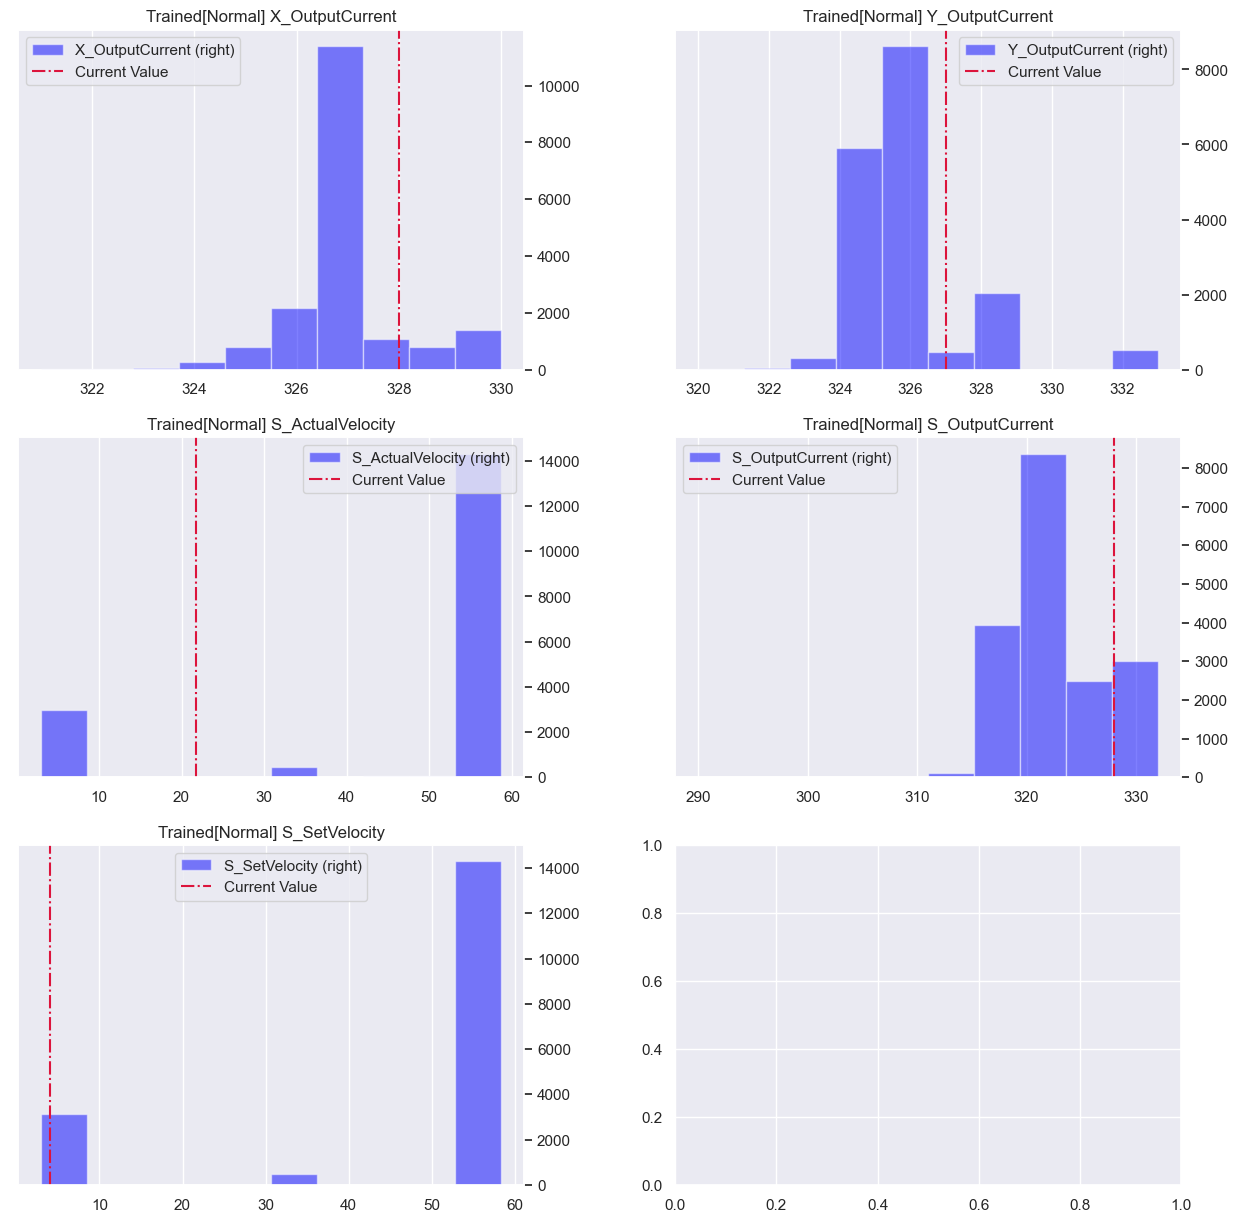

In [19]:
input_df = pred_fault[pred_fault['_id'] == fault_ids[_id]] # 불량 예측 데이터 ID 기준 출력 
print('ID --> ',input_df['_id'].iloc[0])

sns.set(font_scale=1.0)
fig, ax = plt.subplots(3,2, figsize=(15,15)) # 데이터 개수에 따라 플롯 형태 변경 가능 
fig.subplots_adjust(hspace = .2, wspace=.3, )
ax = ax.ravel()
for i in range(len(imp_cols)):
    ax[i] = Trained_Normal[imp_cols].iloc[:,i].plot(kind='hist', ax=ax[i],color='blue',alpha=0.5,secondary_y=True,bins=10)
    plt.axvline(input_df[imp_cols].iloc[:,i].iloc[0],linestyle='dashdot',color='crimson',label='Current Value')
    plt.legend()
    plt.title('Trained[Normal] ' +Trained_Normal[imp_cols].columns[i])

Id -->  ID_20231108_0
Normal Probability :  0.3861800364741585
Fault Probability :  0.6138199635258416


Columns: ['X_OutputCurrent', 'Y_OutputCurrent', 'S_ActualVelocity', 'S_OutputCurrent', 'S_SetVelocity']
Column Values: [328, 327, 21.7, 328, 4.0]
Median Normal Values: [327.0, 326.0, 58.2, 322.0, 58.3]
Confidence Range =  | Input - Upper/Lower Boundary | ± 5
Diagnosis Result -->


X_OutputCurrent  =  328


하위 측정값 설정: 327.0
중앙 측정값 : 327.0
상위 10% 측정값 : 329.0


진단 결과
Value in Set Normal Quantile Range
X_OutputCurrent  --> 현재 값 유지




Y_OutputCurrent  =  327


하위 측정값 설정: 325.0
중앙 측정값 : 326.0
상위 10% 측정값 : 328.0


진단 결과
Value in Set Normal Quantile Range
Y_OutputCurrent  --> 현재 값 유지




S_ActualVelocity  =  21.7


하위 측정값 설정: 48.30000000000018
중앙 측정값 : 58.2
상위 10% 측정값 : 58.4


진단 결과
S_ActualVelocity 상향 조정 대상-->  + 26.600000000000183


추천 의사결정 -->  S_ActualVelocity 조정




S_OutputCurrent  =  328


하위 측정값 설정: 319.0
중앙 측정값 : 322.0
상위 10% 측정값 : 329.0


진단 결과
Value in Set Normal Quantile Range


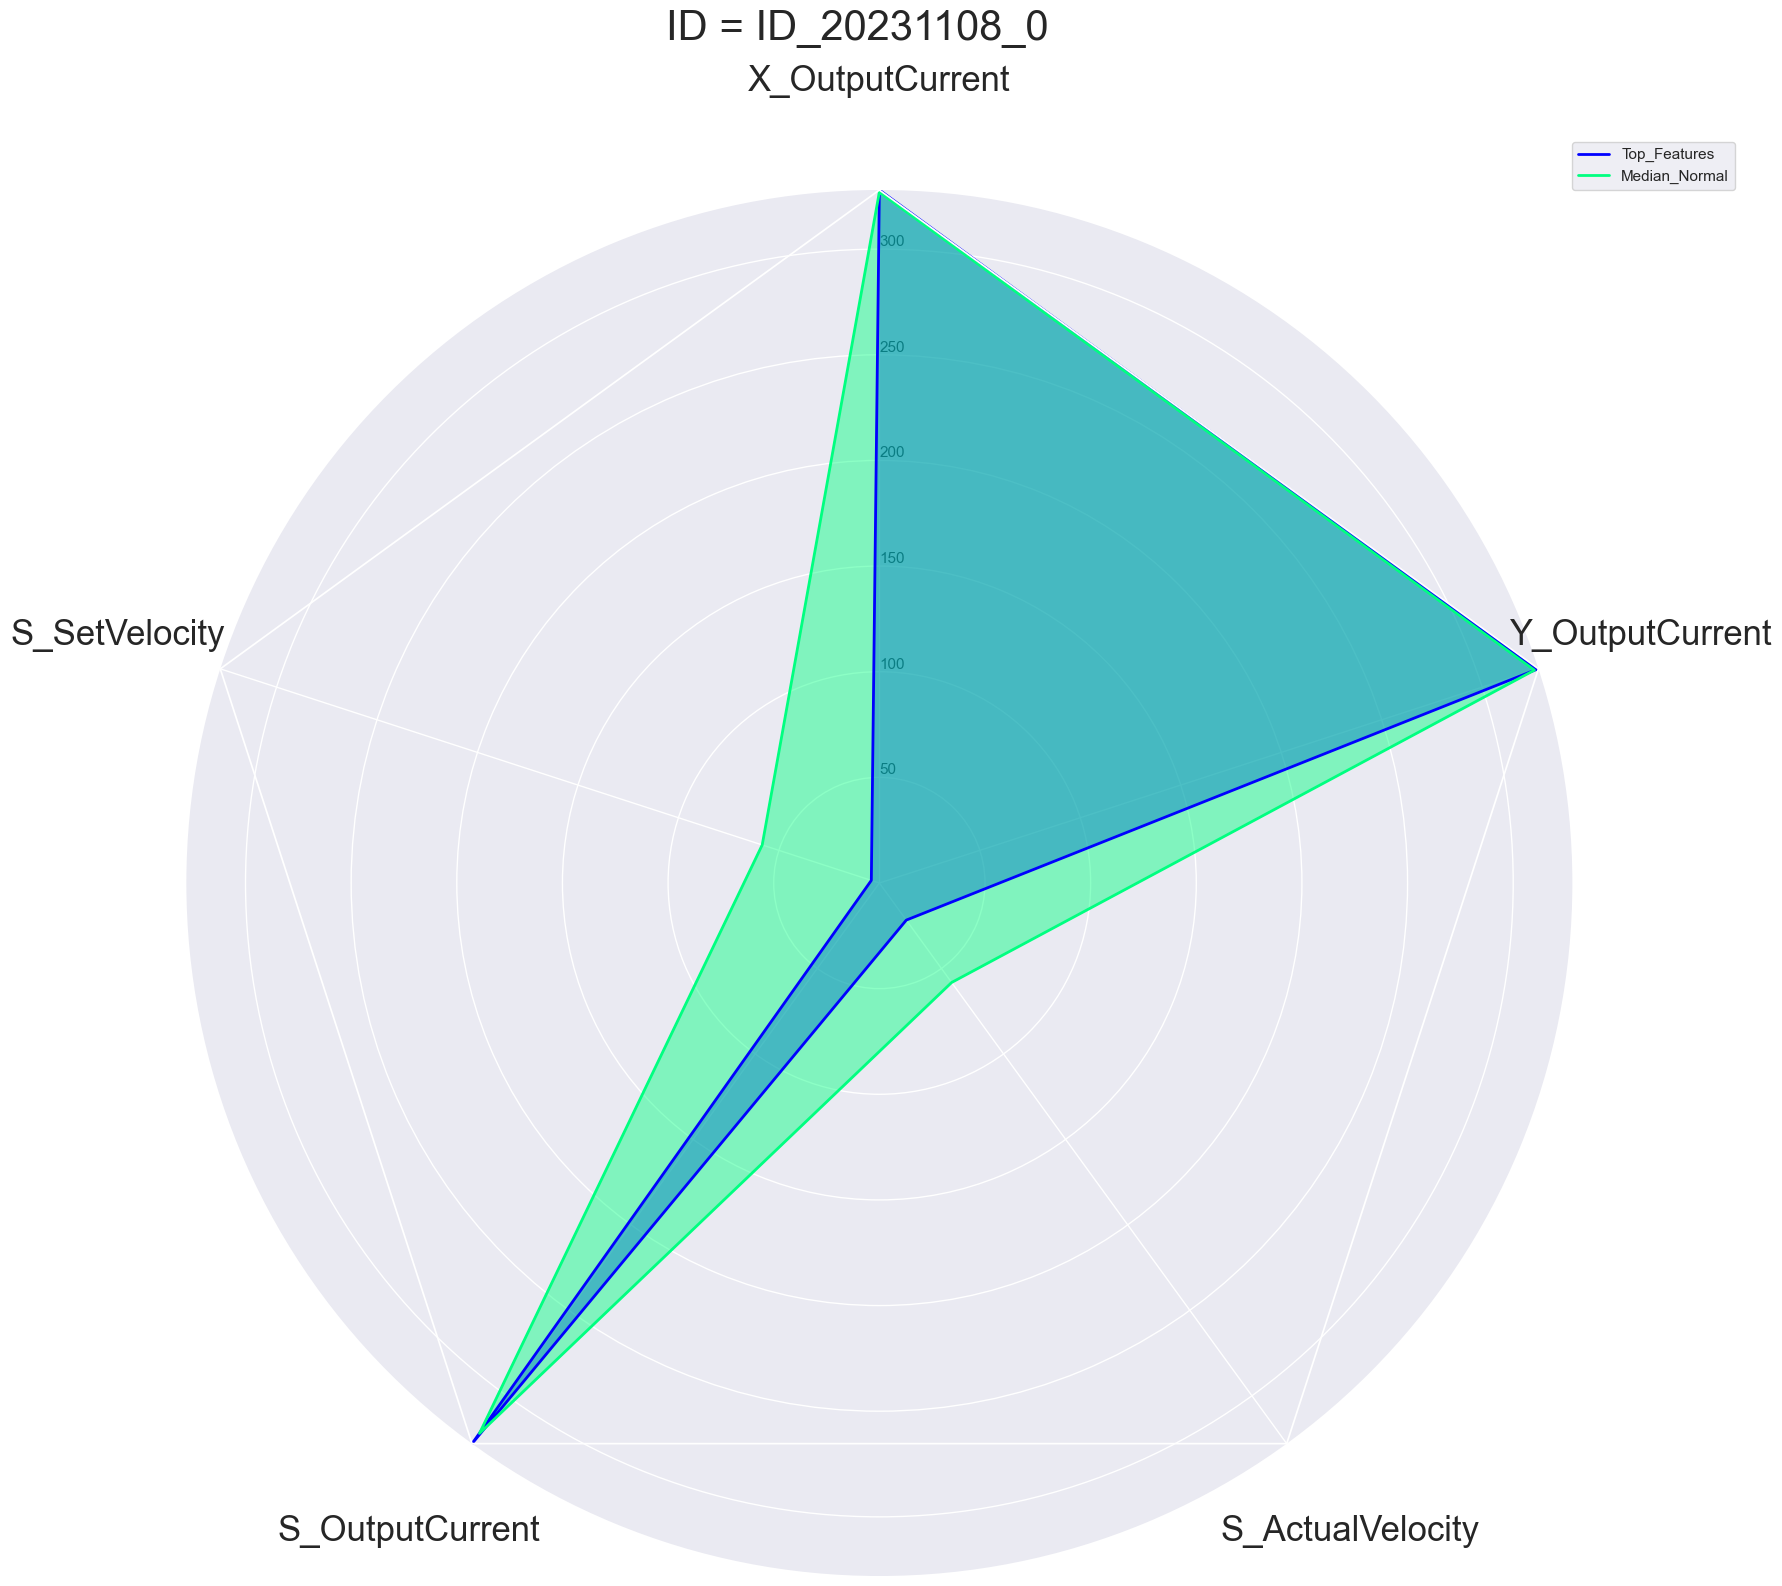

ID_20231108_0 Optimization Result -->


Label : 0
Normal Probability -->  0.7177800861961514
Fault Probability -->  0.2822199138038487


Predicted --> Normal


In [20]:
lower_quantile = 0.2 #0.1
col_range = 5 #1

input_adjusted = comprehensive_fault_diagnosis(_id,lower_quantile,col_range) 
optimization(_id)